In [1]:
from pathlib import Path
import pandas as pd

import ais_query

VERBOSE_MODE = True

FOLDER_NAME = "ais-data"
folder_path = Path(FOLDER_NAME)
parquet_folder_path = folder_path / "parquet"

# DATA LOADING

In [2]:
df = ais_query.query_ais_duckdb(parquet_folder_path, verbose=VERBOSE_MODE)

[query_ais_duckdb] SQL:
 SELECT * FROM read_parquet('ais-data/parquet/**/*.parquet') WHERE 1=1


In [3]:
# TEST
df.head()

,Timestamp,Type of mobile,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,IMO,...,Destination,ETA,Data source type,A,B,C,D,Date,MMSI,Segment
0,2025-11-01 00:39:24,Class A,57.550712,11.270745,Under way using engine,0.0,11.4,138.4,140,9819882,...,DETRV,2025-11-02 02:00:00,AIS,11,106,12,8,2025-11-01,209275000,0
1,2025-11-01 00:39:33,Class A,57.550353,11.271337,Under way using engine,0.0,11.5,138.0,140,9819882,...,DETRV,2025-11-02 02:00:00,AIS,11,106,12,8,2025-11-01,209275000,0
2,2025-11-01 00:39:43,Class A,57.550000,11.271933,Under way using engine,0.0,11.5,137.6,140,9819882,...,DETRV,2025-11-02 02:00:00,AIS,11,106,12,8,2025-11-01,209275000,0
3,2025-11-01 00:39:53,Class A,57.549570,11.272673,Under way using engine,0.0,11.5,136.9,139,9819882,...,DETRV,2025-11-02 02:00:00,AIS,11,106,12,8,2025-11-01,209275000,0
4,2025-11-01 00:40:04,Class A,57.549142,11.273413,Under way using engine,0.0,11.5,137.1,139,9819882,...,DETRV,2025-11-02 02:00:00,AIS,11,106,12,8,2025-11-01,209275000,0


In [4]:
df.drop(columns=[ 'Type of mobile', 'ROT', 'Heading', 'IMO', 
       'Callsign', 'Name', 'Cargo type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'Date'], inplace=True, errors='ignore')

df.dropna(inplace=True)

print(df.columns)

Index(['Timestamp', 'Latitude', 'Longitude', 'Navigational status', 'SOG',
       'COG', 'Ship type', 'MMSI', 'Segment'],
      dtype='object')


# PROCESSING

### Adding DeltaT feature

In [5]:
def add_delta_t(df: pd.DataFrame) -> pd.DataFrame:
    # ensure Timestamp is datetime
    if 'Timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # create Day column so the same Segment number on different days is treated separately
    df['Day'] = df['Timestamp'].dt.date
    # sort including Day to keep chronological order within each day-segment
    df = df.sort_values(["MMSI", "Segment", "Day", "Timestamp"])

    # compute time differences within each (MMSI, Segment, Day) group
    df["DeltaT"] = df.groupby(["MMSI", "Segment", "Day"])["Timestamp"] \
                     .diff().dt.total_seconds().fillna(0)

    # optional: unique per-day segment identifier (useful downstream)
    df['Segment_uid'] = df['MMSI'].astype(str) + '_' + df['Segment'].astype(str) + '_' + df['Day'].astype(str)

    return df

df_delta_t = add_delta_t(df)

### Make segments of a fixed max lenght


In [37]:
SEGMENT_MAX_LENGTH = 30

def split_segments_fixed_length(
    df: pd.DataFrame,
    base_segment_col: str = "Segment_uid",
    max_len: int = 30,
    time_col: str = "Timestamp",
    new_segment_col: str = "Segment_nr",
) -> pd.DataFrame:
    """
    Takes a DataFrame with a base segment id (Segment_uid) that marks
    continuous tracks of arbitrary length, and splits each track into
    fixed-length segments of `max_len` points.

    - Each new segment gets a unique incremental id in `new_segment_col`
    - Leftover points that do not form a full `max_len` chunk are dropped
    """
    df = df.copy()

    # Ensure deterministic ordering inside each original segment
    df = df.sort_values([base_segment_col, time_col])

    # Initialize new segment column
    df[new_segment_col] = -1  # temporary marker: -1 = "not assigned"

    global_segment_counter = 0

    # Process each continuous track independently
    for seg_uid, group in df.groupby(base_segment_col):
        # group is already sorted by time_col due to previous sort,
        # but we can enforce it defensively:
        group = group.sort_values(time_col)

        n_points = len(group)
        n_full_chunks = n_points // max_len  # integer division

        # For each full chunk of `max_len` points
        for i in range(n_full_chunks):
            global_segment_counter += 1

            start_idx = i * max_len
            end_idx = start_idx + max_len

            # Select rows by POSITION within the group, then map back to df by index
            idx = group.iloc[start_idx:end_idx].index

            # Assign the new segment id
            df.loc[idx, new_segment_col] = global_segment_counter

        # Any leftover points (n_points % max_len) are simply ignored
        # because their Segment_nr stays = -1

    # Drop rows that do not belong to a full segment of length max_len
    df = df[df[new_segment_col] != -1].copy()

    return df



df_segmented = split_segments_fixed_length(df_delta_t, max_len=SEGMENT_MAX_LENGTH)
df_segmented.drop(columns=["Day", "Segment", "Segment_uid"], inplace=True)

### Normalizing

In [ ]:
NUMERIC_COLS = [
    "Latitude", 
    "Longitude",
    "SOG",
    "COG",
    "DeltaT"
]

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    all_values = df[NUMERIC_COLS].to_numpy(dtype=float)

    mean = all_values.mean(axis=0)
    std = all_values.std(axis=0)
    # avoid division by zero
    std[std == 0] = 1.0

    df_norm = df.copy()
    df_norm[NUMERIC_COLS] = (df_norm[NUMERIC_COLS] - mean) / std
    return df_norm

df_normalized = normalize_df(df_segmented)

In [ ]:
df_normalized.groupby("Segment_nr").size().value_counts() # check segment lengths

30    10524
Name: count, dtype: int64

### Categorical features encoding

##### Navigational status (dynamic)

In [ ]:
# Create an integer ID for each navigational status value
df_normalized["NavStatusID"] = df_normalized["Navigational status"].astype("category").cat.codes

# save the mapping for future reference (optional but recommended)
nav_cat = df_normalized["Navigational status"].astype("category")
nav_label_to_id = dict(enumerate(nav_cat.cat.categories))   # id -> label

# ONE-HOT ENCODING
nav_dummies = pd.get_dummies(df_normalized["NavStatusID"], prefix="NavStatus")

# concateni al df
df_normalized = pd.concat([df_normalized, nav_dummies], axis=1)

# Dropping original columns
df_normalized = df_normalized.drop(columns=["Navigational status", "NavStatusID"])


In [46]:
NAV_ONEHOT_COLS = [c for c in df_normalized.columns if c.startswith("NavStatus_")]
print(NAV_ONEHOT_COLS)

['NavStatus_0', 'NavStatus_1', 'NavStatus_2', 'NavStatus_3', 'NavStatus_4', 'NavStatus_5', 'NavStatus_6']


##### Ship type (static) - to be inject to latent space

In [45]:
df_normalized["ShipTypeID"] = df_normalized["Ship type"].astype("category").cat.codes

ship_cat = df_normalized["Ship type"].astype("category")
ship_label_to_id = dict(enumerate(ship_cat.cat.categories))  # id -> label

df_normalized.drop(columns=["Ship type"], inplace=True)

In [48]:
NUMERIC_COLS = ["Latitude", "Longitude", "SOG", "COG", "DeltaT"]
print(NUMERIC_COLS)

['Latitude', 'Longitude', 'SOG', 'COG', 'DeltaT']


### Pre-training data preparation

##### Now we are saving a list of sequnces of shape (30, F_tot), along its metadata (Segment_nr, MMSI, ShipTypeID)

In [54]:
FEATURE_COLS = NUMERIC_COLS + NAV_ONEHOT_COLS
sequences = []
groups = df_normalized.groupby("Segment_nr")

for seg_id, g in groups:
    g = g.sort_values("Timestamp")  # or Timestamp; important is temporal order
    if len(g) != 30:
        continue  # safety: skip anomalous segments

    X = g[FEATURE_COLS].to_numpy(dtype=float)  # shape (30, F_tot)
    ship_type_id = int(g["ShipTypeID"].iloc[0])
    mmsi = g["MMSI"].iloc[0]

    sequences.append({
        "Segment_nr": seg_id,
        "MMSI": mmsi,
        "ShipTypeID": ship_type_id,
        "Sequence": X,
    })

df_seq = pd.DataFrame(sequences)

In [60]:
df_seq.head()

,Segment_nr,MMSI,ShipTypeID,Sequence
0,1,209275000,7,"[[1.8815514162062317, -0.2202928483766348, 0.5..."
1,2,209275000,7,"[[1.7429914702568756, -0.1387357466948971, 0.5..."
2,3,209275000,7,"[[1.6073910571335495, -0.05852931881763665, 0...."
3,4,209275000,7,"[[1.479803608381263, 0.01902458098577772, 0.48..."
4,5,209275000,7,"[[1.3481921308061502, 0.10068339003230646, 0.4..."


# LSTM

##### Dataset

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

class AISTrajectoryDataset(Dataset):
    def __init__(self, df_seq: pd.DataFrame):
        # Save a copy and reset index
        self.df = df_seq.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Sequence: list-of-lists -> numpy -> tensor (30, F)
        seq = np.array(row["Sequence"], dtype=np.float32)
        x = torch.from_numpy(seq)  # shape (30, F)

        # ShipTypeID: integer -> tensor (for future embedding)
        ship_type_id = int(row["ShipTypeID"])
        ship_type_id = torch.tensor(ship_type_id, dtype=torch.long)

        return x, ship_type_id


In [70]:
dataset = AISTrajectoryDataset(df_seq)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# sanity check:
x_batch, st_batch = next(iter(dataloader))
print(x_batch.shape)   # -> [batch_size, 30, F]
print(st_batch.shape)  # -> [batch_size]


torch.Size([64, 30, 12])
torch.Size([64])


##### Model

In [ ]:
class LSTMVAEWithShipType(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dim: int,
                 latent_dim: int,
                 num_shiptypes: int,
                 shiptype_emb_dim: int = 8,
                 num_layers: int = 1):
        super().__init__()

        # ----- ENCODER -----
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers,
                               batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # ----- SHIP TYPE EMBEDDING -----
        self.shiptype_emb = nn.Embedding(num_shiptypes, shiptype_emb_dim)

        # ----- DECODER -----
        # we'll concatenate z and shiptype_emb, then map to initial hidden state
        self.fc_z_st_to_h = nn.Linear(latent_dim + shiptype_emb_dim, hidden_dim)

        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers,
                               batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    # ---- core VAE ops ----

    def encode(self, x):
        # x: (B, T, F)
        _, (h_n, _) = self.encoder(x)
        h_T = h_n[-1]           # (B, hidden_dim)
        mu = self.fc_mu(h_T)    # (B, latent_dim)
        logvar = self.fc_logvar(h_T)  # (B, latent_dim)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std   # (B, latent_dim)

    def decode(self, x, z, ship_type_ids):
        """
        x: (B, T, F)  - original sequence (teacher forcing)
        z: (B, latent_dim)
        ship_type_ids: (B,)
        """
        # ship type embedding
        st_emb = self.shiptype_emb(ship_type_ids)       # (B, shiptype_emb_dim)

        # concatenate z and ship type embedding
        z_cond = torch.cat([z, st_emb], dim=1)          # (B, latent_dim+emb_dim)

        # map to initial hidden state of decoder
        h0 = torch.tanh(self.fc_z_st_to_h(z_cond))      # (B, hidden_dim)
        h0 = h0.unsqueeze(0)                            # (1, B, hidden_dim)
        c0 = torch.zeros_like(h0)                       # (1, B, hidden_dim)

        out, _ = self.decoder(x, (h0, c0))              # (B, T, hidden_dim)
        recon = self.fc_out(out)                        # (B, T, F)
        return recon

    def forward(self, x, ship_type_ids):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(x, z, ship_type_ids)
        return recon, mu, logvar

##### Loss functions: reconstruction + KL

In [72]:
def reconstruction_loss(x, recon_x):
    # MSE over (B, T, F)
    return torch.mean((x - recon_x) ** 2)

def kl_loss(mu, logvar):
    # KL(q(z|x) || N(0, I)) per batch
    # mu, logvar: (B, latent_dim)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kld.mean()

##### Instantiating the model

In [73]:
num_shiptypes = df_seq["ShipTypeID"].nunique()
print("num_shiptypes =", num_shiptypes)


num_shiptypes = 11


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_x, _ = dataset[0]
T, F = sample_x.shape

model = LSTMVAEWithShipType(
    input_dim=F,
    hidden_dim=64,        # tune this
    latent_dim=16,        # tune this
    num_shiptypes=num_shiptypes,
    shiptype_emb_dim=8,   # small embedding is enough
    num_layers=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
beta = 1e-3  # weight for KL term, you can tune this


##### Training loop: VAE + ship type

In [75]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_rec = 0.0
    total_kl = 0.0

    for x, ship_type_id in dataloader:
        x = x.to(device)                      # (B, T, F)
        ship_type_id = ship_type_id.to(device)

        recon, mu, logvar = model(x, ship_type_id)

        rec = reconstruction_loss(x, recon)
        kld = kl_loss(mu, logvar)
        loss = rec + beta * kld

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_rec  += rec.item() * x.size(0)
        total_kl   += kld.item() * x.size(0)

    N = len(dataset)
    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- loss: {total_loss/N:.6f} "
        f"- rec: {total_rec/N:.6f} "
        f"- kl: {total_kl/N:.6f}"
    )


Epoch 1/10 - loss: 0.149982 - rec: 0.148605 - kl: 1.376915
Epoch 2/10 - loss: 0.012701 - rec: 0.011718 - kl: 0.983210
Epoch 2/10 - loss: 0.012701 - rec: 0.011718 - kl: 0.983210
Epoch 3/10 - loss: 0.003981 - rec: 0.003692 - kl: 0.288859
Epoch 3/10 - loss: 0.003981 - rec: 0.003692 - kl: 0.288859
Epoch 4/10 - loss: 0.002026 - rec: 0.001953 - kl: 0.072457
Epoch 4/10 - loss: 0.002026 - rec: 0.001953 - kl: 0.072457
Epoch 5/10 - loss: 0.001200 - rec: 0.001182 - kl: 0.017042
Epoch 5/10 - loss: 0.001200 - rec: 0.001182 - kl: 0.017042
Epoch 6/10 - loss: 0.000787 - rec: 0.000781 - kl: 0.005404
Epoch 6/10 - loss: 0.000787 - rec: 0.000781 - kl: 0.005404
Epoch 7/10 - loss: 0.000567 - rec: 0.000564 - kl: 0.002755
Epoch 7/10 - loss: 0.000567 - rec: 0.000564 - kl: 0.002755
Epoch 8/10 - loss: 0.000431 - rec: 0.000430 - kl: 0.001503
Epoch 8/10 - loss: 0.000431 - rec: 0.000430 - kl: 0.001503
Epoch 9/10 - loss: 0.000344 - rec: 0.000343 - kl: 0.000886
Epoch 9/10 - loss: 0.000344 - rec: 0.000343 - kl: 0.0008

# Performance check

### Real vs reconstructed

In [76]:
FEATURE_NAMES = [
    "Latitude",
    "Longitude",
    "SOG",
    "COG",
    "DeltaT",
    "NavStatus_0",
    "NavStatus_1",
    "NavStatus_2",
    "NavStatus_3",
    "NavStatus_4",
    "NavStatus_5",
    "NavStatus_6",
]


In [77]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_original_vs_recon(
    model,
    dataloader,
    device,
    feature_names,
    num_examples: int = 3
):
    model.eval()
    feature_names = list(feature_names)
    
    with torch.no_grad():
        # get a single batch
        x_batch, ship_type_batch = next(iter(dataloader))
        x_batch = x_batch.to(device)              # (B, T, F)
        ship_type_batch = ship_type_batch.to(device)
        
        recon_batch, mu, logvar = model(x_batch, ship_type_batch)
        
        x_batch = x_batch.cpu().numpy()
        recon_batch = recon_batch.cpu().numpy()
    
    B, T, F = x_batch.shape
    num_examples = min(num_examples, B)
    
    for i in range(num_examples):
        orig = x_batch[i]   # (T, F)
        rec  = recon_batch[i]
        
        print(f"\nPlotting example {i} (sequence index {i})")
        
        # grid layout for subplots
        n_features = F
        n_cols = 2
        n_rows = math.ceil(n_features / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), squeeze=False)
        
        time_steps = np.arange(T)
        
        for f_idx in range(n_features):
            row = f_idx // n_cols
            col = f_idx % n_cols
            
            ax = axes[row][col]
            
            fname = feature_names[f_idx] if f_idx < len(feature_names) else f"feat_{f_idx}"
            
            ax.plot(time_steps, orig[:, f_idx], label="original")
            ax.plot(time_steps, rec[:, f_idx], linestyle="--", label="reconstructed")
            
            ax.set_title(fname)
            ax.set_xlabel("timestep")
            ax.set_ylabel("value")
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        # hide any empty subplots if F is odd
        for f_idx in range(n_features, n_rows * n_cols):
            row = f_idx // n_cols
            col = f_idx % n_cols
            fig.delaxes(axes[row][col])
        
        fig.tight_layout()
        plt.show()



Plotting example 0 (sequence index 0)


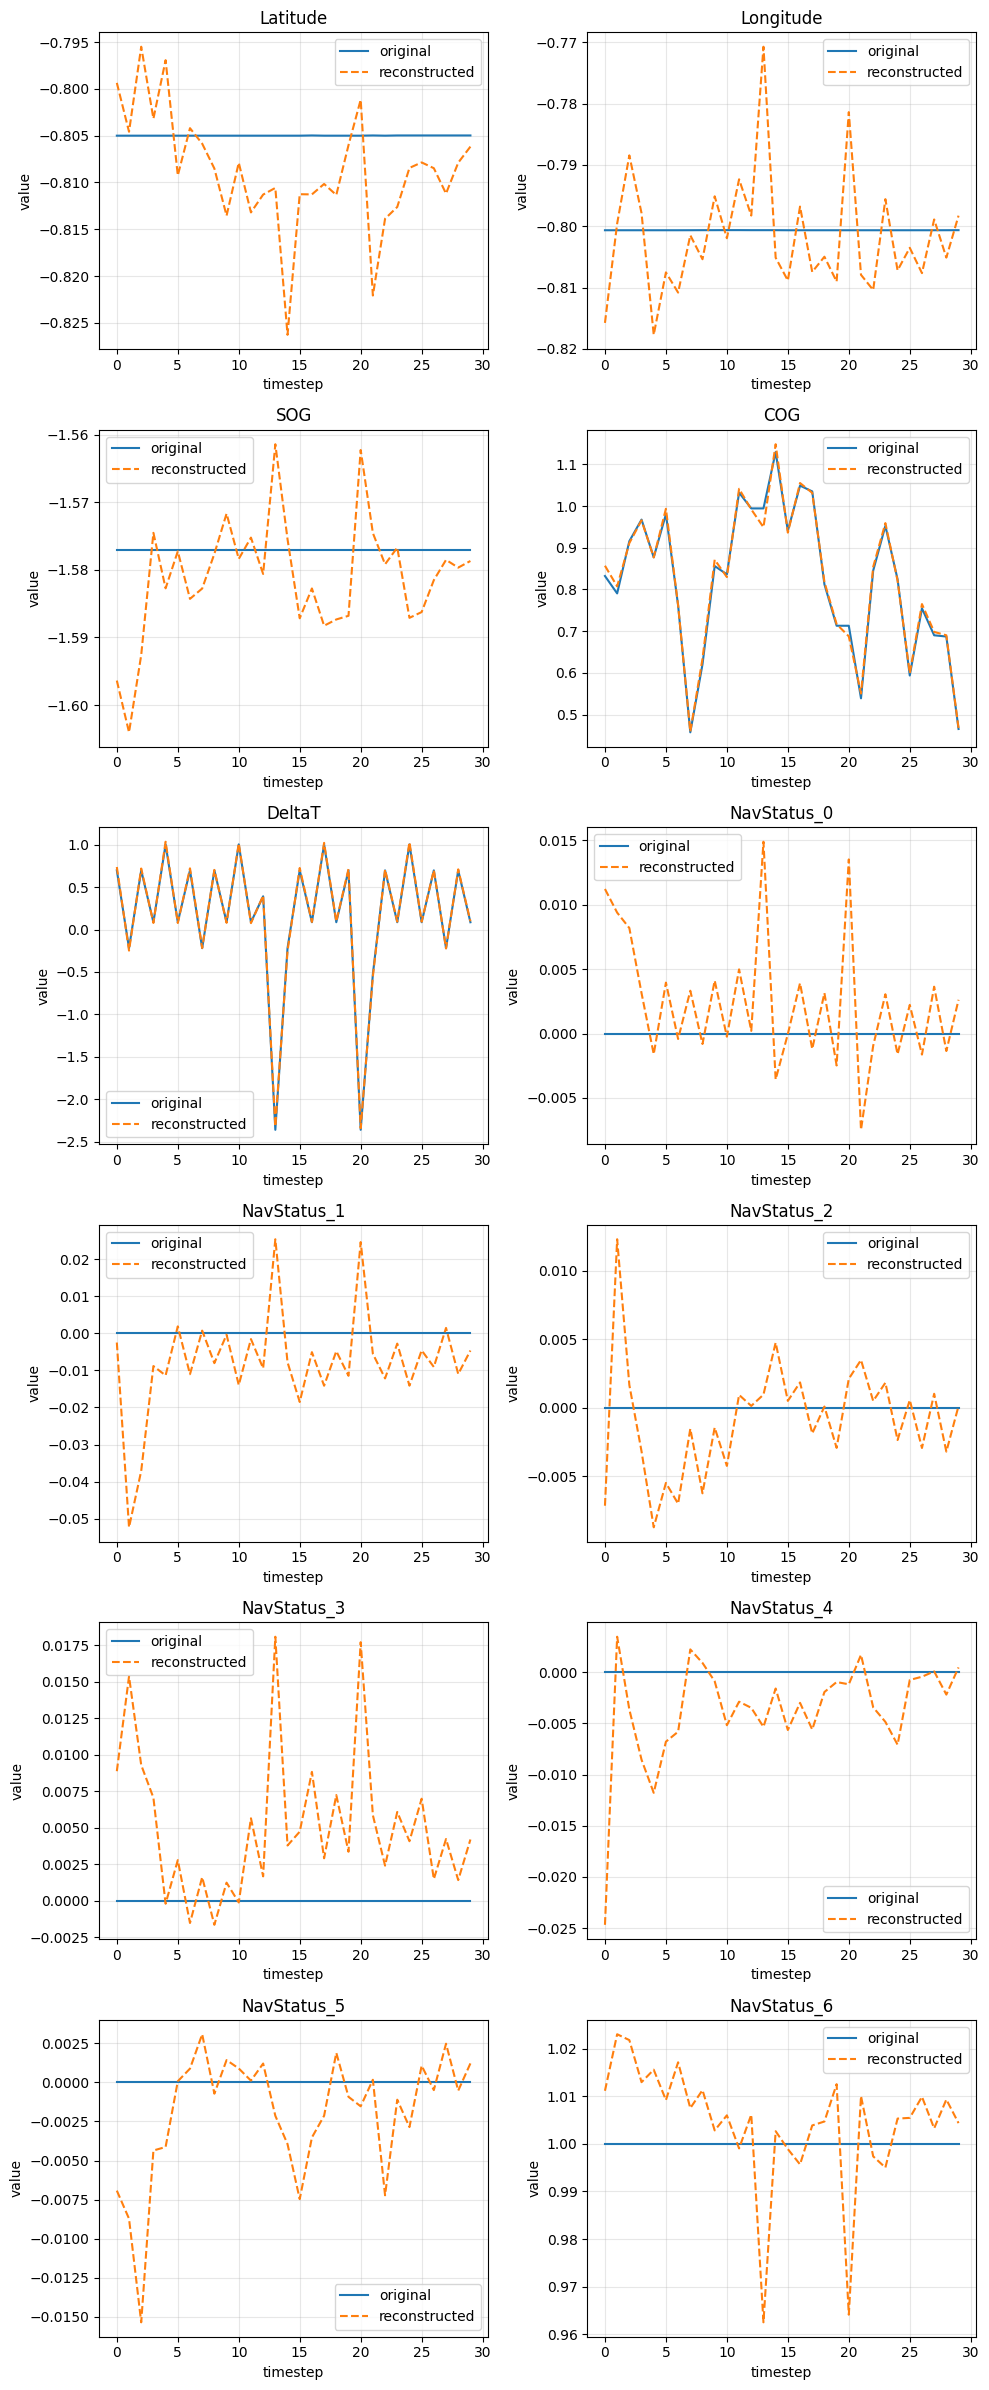


Plotting example 1 (sequence index 1)


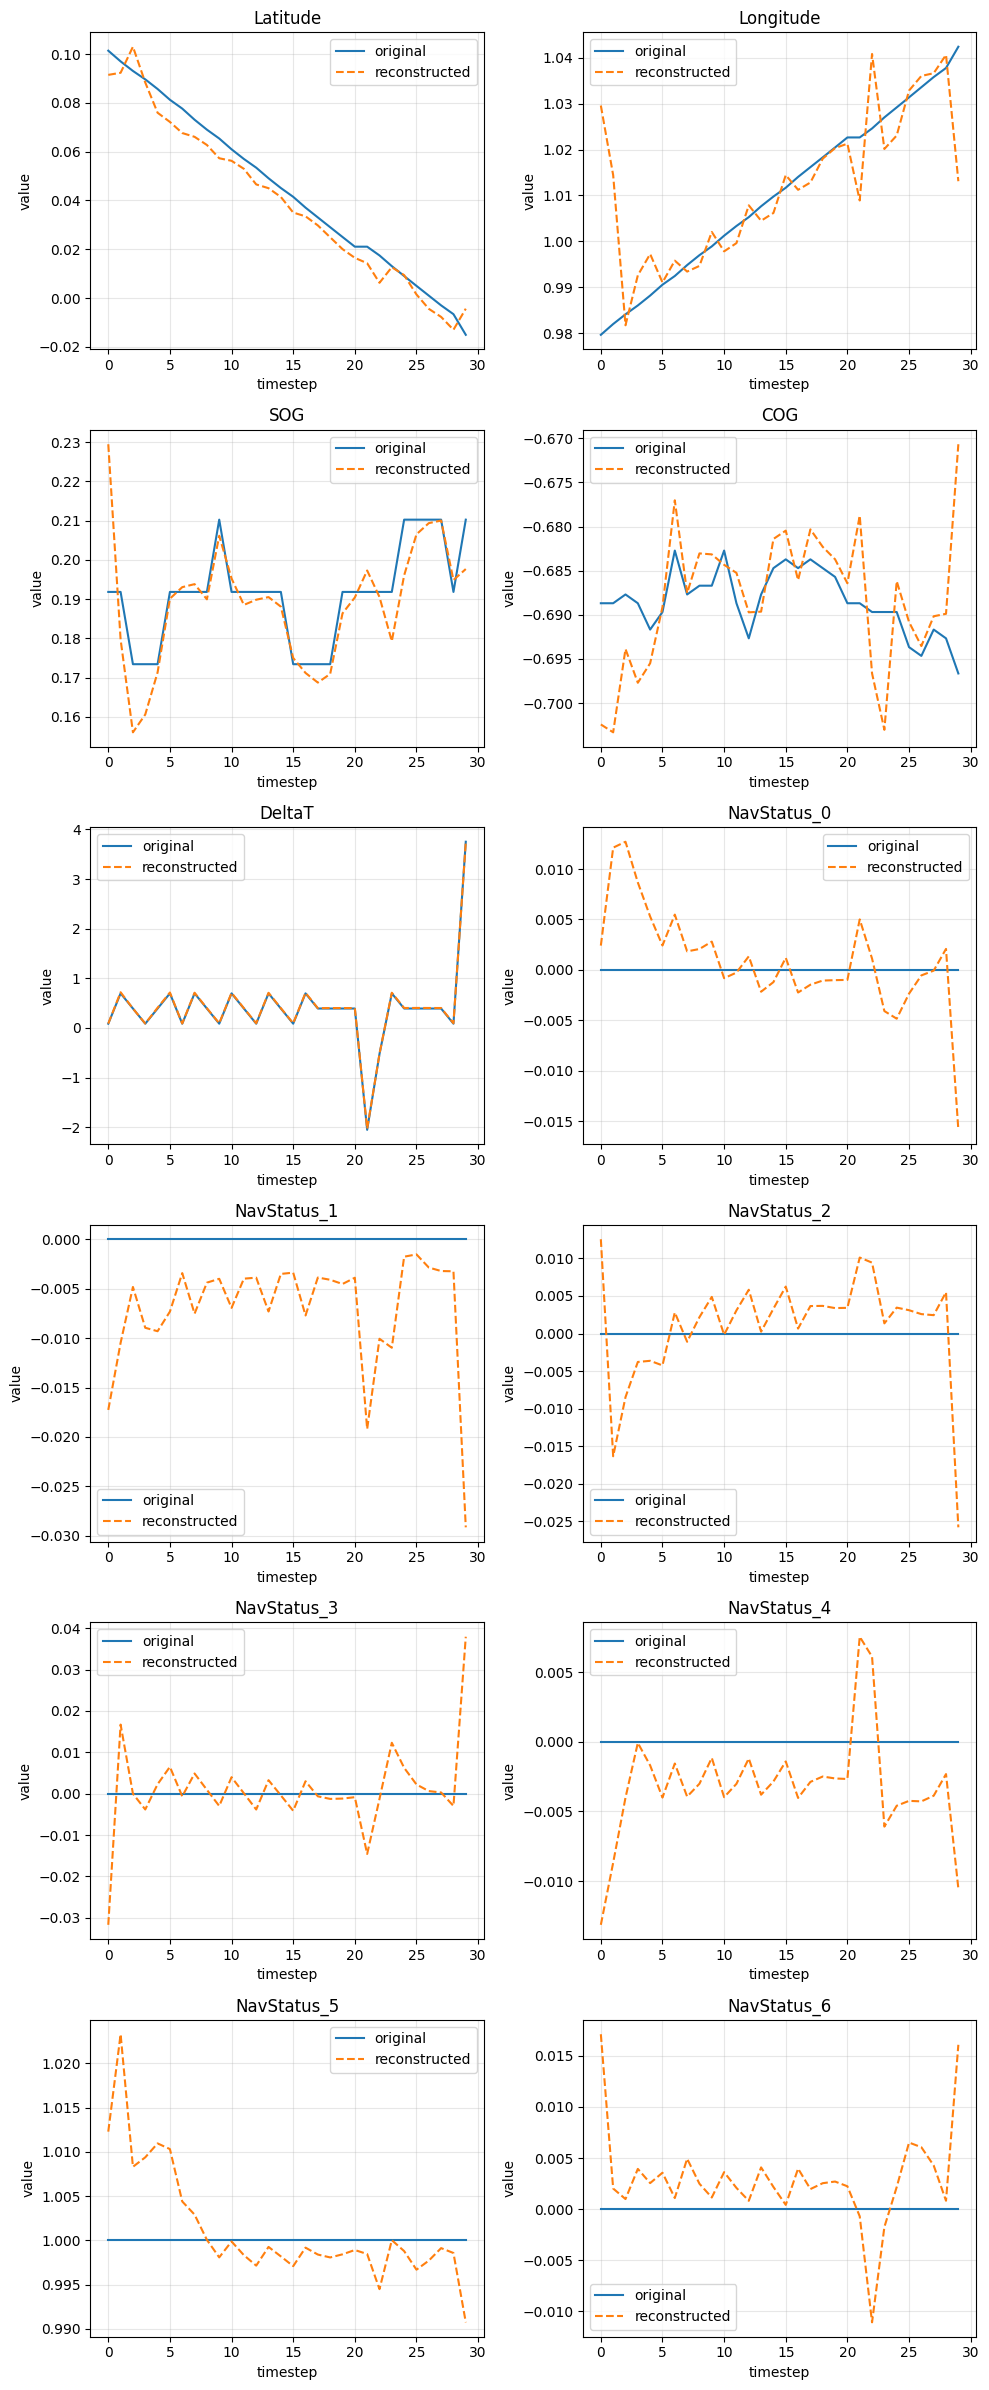


Plotting example 2 (sequence index 2)


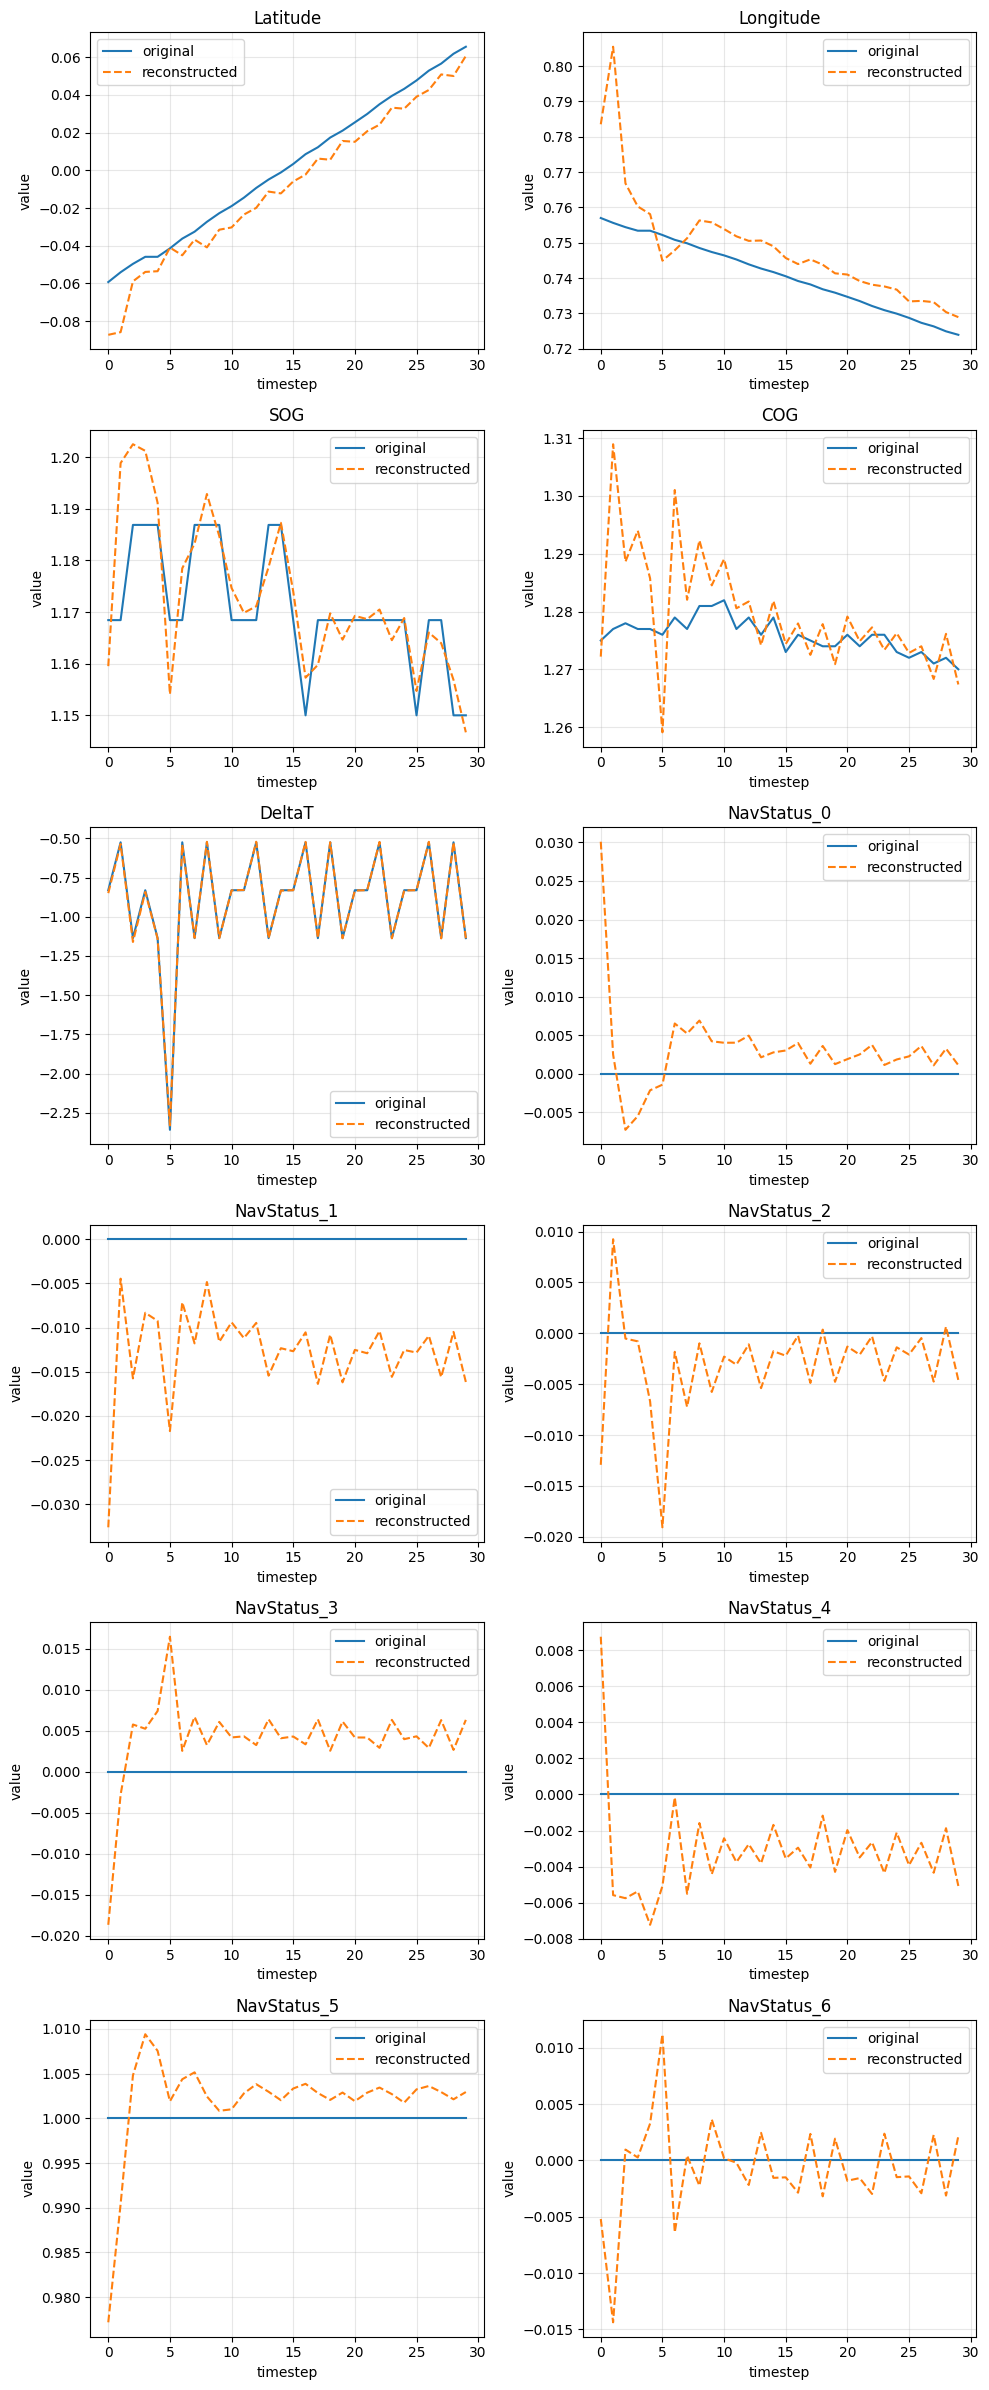

In [78]:
plot_original_vs_recon(
    model=model,
    dataloader=dataloader,
    device=device,
    feature_names=FEATURE_NAMES,
    num_examples=3,   # how many sequences to inspect from the batch
)
